<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 04 - U-Net no Processo Reverso**

Na aula anterior, vocês aprenderam como o processo de difusão adiciona ruído progressivamente às imagens (o chamado processo *forward*), simulando uma cadeia de Markov reversível. Isso nos ajudou a entender a entropia crescente e o conceito de aprender a "desfazer" o ruído.

Agora nesta aula, vamos dar um passo adiante: começaremos a construir a rede neural capaz de realizar o processo *reverse* (ou seja, reconstruir a imagem original a partir de uma versão ruidosa).  
Para isso, usaremos a arquitetura U-Net, muito popular em tarefas de segmentação, geração e restauração de imagens, graças à sua capacidade de capturar detalhes finos via *skip connections*.


In [ ]:
!pip install torchview -q

In [ ]:
# Bibliotecas padrão
import math
import numpy as np
import textwrap
import random
import kagglehub
import shutil
import os
import pandas as pd

# Bibliotecas de visualização
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as Im2
import imageio

# Bibliotecas PyTorch, torchvision e estatisticas
import torch, torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchview import draw_graph
from torchvision.utils import make_grid
from torchvision.transforms import v2
from scipy.stats import norm

device = "cuda" if torch.cuda.is_available() else "cpu"

## **Preparação do Dataset**

Antes de definirmos a U-Net, precisamos preparar o dataset e garantir que temos todas as bibliotecas corretas instaladas. Vamos também definir as transformações que normalizam as imagens no intervalo `[-1, 1]`, padrão que usaremos ao longo de todo o treinamento.

### **Carregamento e pré-processamento**

In [ ]:
# Baixar dataset
dataset_path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

# Definir destino no /content
destination_path = '/content/pixel-art'

# Copiar para /content
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)
print("Dataset copiado para:", destination_path)

100%|██████████| 85.7M/85.7M [00:05<00:00, 16.1MB/s]

Extracting files...


Dataset copiado para: /content/pixel-art


Para lidar com as imagens e rótulos do nosso projeto, vamos fazer uma alteração da classe `PixelArtDataset`, para permitir filtrar as imagens por valores específicos do rótulo.

In [ ]:
class PixelArtDataset(Dataset):
    def __init__(self, images_dir, captions_file=None, transform=None,
                 filter_label_value=None, filter_index=0):
        self.transform = transform
        self.captions = {}

        # Buscar todas as imagens recursivamente na pasta
        self.image_files = []
        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.image_files.append(os.path.join(root, file))

        # Se tiver um arquivo CSV com rótulos, carrega no dicionário
        if captions_file:
            df = pd.read_csv(captions_file)
            self.captions = {
                self.force_extension(os.path.basename(path).lower(), ".png"):
                    np.fromstring(label.strip("[]"), sep=" ").tolist()
                for path, label in zip(df['Image Path'], df['Label'])
            }

        # Se filter_label_value for passado, filtra image_files
        if filter_label_value is not None:
            filtered = []
            for img_path in self.image_files:
                img_name = os.path.basename(img_path).lower()
                img_name = self.force_extension(img_name, ".png")
                label = self.captions.get(img_name)
                if label and len(label) > filter_index and label[filter_index] == filter_label_value:
                    filtered.append(img_path)
            self.image_files = filtered

    def __len__(self):
        return len(self.image_files)

    def force_extension(self, filename, ext=".png"):
        return os.path.splitext(filename)[0] + ext

    def __getitem__(self, idx):
        # Recupera caminho e nome da imagem
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path).lower()
        img_name = self.force_extension(img_name, ".png")

        # Abre a imagem e converte para RGB
        image = Image.open(img_path).convert('RGB')

        # Aplica transformações caso existam
        if self.transform:
            image = self.transform(image)

        # Recupera o label do dicionário, se existir. Senão preenche com zeros
        label = self.captions.get(img_name, [0.0]*5)

        # Retorna dict com a imagem e o tensor do label
        return {
            "image": image,
            "label": torch.tensor(label, dtype=torch.float32)
        }

In [ ]:
# Transformação básica para normalizar para [-1,1]
transform = transforms.Compose([
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# Dataset e DataLoader
dataset = PixelArtDataset(
    "/content/pixel-art/images",
    captions_file="/content/pixel-art/labels.csv",
    transform=transform,
    filter_label_value=1.0,
    filter_index=3)

# Carrega dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print(len(dataset))

34999


Visualizando 16 amostras do dataset


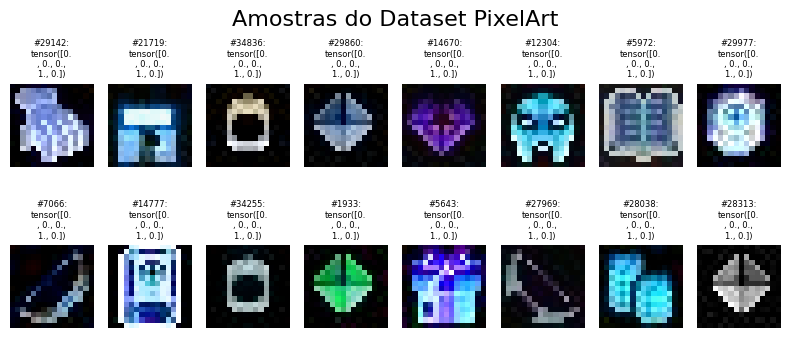

In [ ]:
# Seleciona aleatoriamente até 16 índices do dataset
indices = np.random.choice(len(dataset), size=min(16, len(dataset)), replace=False)
print(f"Visualizando {len(indices)} amostras do dataset")

# Define grid para exibição: 8 colunas e número de linhas necessário
cols = 8
rows = (len(indices) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))

# Garante que axes tenha sempre shape 2D para facilitar o loop
axes = np.atleast_2d(axes)

# Itera sobre cada índice selecionado e plota no grid
for i, idx in enumerate(indices):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sample = dataset[idx]

    # Recupera imagem e label
    image = sample['image']
    label = sample['label']

    # Desnormaliza de [-1,1] para [0,1]
    img_vis = torch.clamp((image * 0.5) + 0.5, 0, 1)
    img_np = img_vis.permute(1, 2, 0).cpu().numpy()

    # Plota a imagem
    ax.imshow(img_np)
    ax.axis('off')

    # Formata o texto do label em múltiplas linhas
    label = "\n".join(textwrap.wrap(str(label), width=10))
    ax.set_title(f"#{idx}:\n{label}", fontsize=6, pad=5)

# Oculta subplots vazios
total_slots = rows * cols
for i in range(len(indices), total_slots):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

# Título geral do grid
plt.suptitle("Amostras do Dataset PixelArt", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## **Implementando a Mini-U-Net em PyTorch**

Agora vamos dar início à construção do modelo que aprenderá a reverter o ruído passo a passo.  
Mas por que a U-Net?

- A U-Net possui um encoder-decoder simétrico com *skip connections*, permitindo preservar detalhes espaciais importantes durante a reconstrução. Isso é crucial em tarefas onde precisamos manter o conteúdo original da imagem, apenas corrigindo a degradação causada pelo ruído.


### **Construção da UNet**

Em seguida, implementamos o embedding senoidal do tempo para representar cada timestep `t`, essencial para informar ao modelo quanto de ruído já foi adicionado. Depois, montamos a U-Net por partes: o `ConvBlock` faz a convolução, normalização e soma o embedding temporal; os blocos `Down` e `Up` cuidam de reduzir e restaurar a resolução espacial, aproveitando as `skip connections` para manter detalhes importantes. Finalmente, ligamos tudo na `MiniUNet`, conectando o `encoder`, `bottleneck` e `decoder`.

### **Embeddings de Tempo**

In [ ]:
# Embedding senoidal de tempo
def sinusoidal_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device, dtype=torch.float32) / (half - 1))
    emb = t[:, None].float() * freqs[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=1)

### **Blocos de Convolução**

In [ ]:
# Bloco convolucional que incorpora um embedding temporal
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim, groups=8):
        super().__init__()
        # Convolução 3x3 que mantém a dimensão espacial (padding=1)
        self.conv  = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        # Normalização por grupos (GroupNorm é estável para batch pequeno)
        self.norm  = nn.GroupNorm(groups, out_ch)
        # Ativação não-linear (SiLU ≈ swish, smooth)
        self.act   = nn.SiLU()
        # Projeção linear do embedding temporal para o shape do canal
        self.time  = nn.Linear(t_dim, out_ch)

        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # Guarda input original para skip connection
        residual = self.skip(x)

        # Passa pelas operações espaciais: conv -> norm -> ativação
        h = self.conv(x)
        h = self.norm(h)
        h = self.act(h)

        # Adiciona o embedding temporal, expandindo para broadcast
        t_proj = self.time(t_emb)[:, :, None, None]
        h = h + t_proj

        return h + residual


### **Downsampling e Upsampling**

In [ ]:
# Módulo de downsampling
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        # Dois blocos convolucionais com embedding temporal
        self.block1 = ConvBlock(in_ch,  out_ch, t_dim)
        self.block2 = ConvBlock(out_ch, out_ch, t_dim)
        # Reduz a resolução pela metade (stride=2)
        self.pool   = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t_emb):
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        p = self.pool(x)
        return x, p  # retorna feature para skip e output reduzido

# Módulo de upsampling
class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, t_dim):
        super().__init__()
        # Aumenta a resolução pela metade com transposed conv
        self.up     = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        # Concatena skip connection e processa
        self.block1 = ConvBlock(out_ch + skip_ch, out_ch, t_dim)
        self.block2 = ConvBlock(out_ch, out_ch, t_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)
        # Concatena canal do skip connection
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        return x

Agora montaremos a classe `UNet`, conectando todos os blocos que definimos anteriormente. No `forward`, ela irá processar a imagem e o embedding temporal, passando pelos níveis de downsampling e upsampling, e aprendendo como remover o ruído.

In [ ]:
class MiniUNet(nn.Module):
    def __init__(self,
                 in_channels=3,
                 base_channels=32,
                 time_dim=128):
        super().__init__()
        # MLP para processar embedding temporal
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # Encoder (downsampling)
        self.down1 = Down(in_channels, base_channels, time_dim)
        self.down2 = Down(base_channels, base_channels*2, time_dim)

        # Bottleneck
        self.bot1 = ConvBlock(base_channels*2, base_channels*4, time_dim)
        self.bot2 = ConvBlock(base_channels*4, base_channels*2, time_dim)

        # Decoder (upsampling)
        self.up2   = Up(base_channels*2, base_channels*2, base_channels, time_dim)
        self.up1   = Up(base_channels, base_channels, base_channels, time_dim)

        # Saída final (reconstrói imagem ou ruído)
        self.out   = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, kernel_size=1)
        )

    def forward(self, x, t):
        # Cria embedding temporal
        t_emb = sinusoidal_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)

        # Encoder: reduz resolução, guarda skips
        s1, p1 = self.down1(x, t_emb)   # s1: feature para skip
        s2, p2 = self.down2(p1, t_emb)

        # Bottleneck: processamento profundo
        b  = self.bot1(p2, t_emb)
        b  = self.bot2(b,  t_emb)

        # Decoder: reconstrói resolução e usa skips
        u2 = self.up2(b,  s2, t_emb)
        u1 = self.up1(u2, s1, t_emb)

        # Saída final
        return self.out(u1)

## **Gerando ruído incremental simplificado**

In [ ]:
def q_sample(x0, t, noise):
    t = t.to(x0.device)

    # Extrai sqrt(ᾱ_t) para cada t do batch e adiciona dimensões extras
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)

    # Extrai sqrt(1 - ᾱ_t) de mesmo modo
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1)

    # Retorna sqrt(ᾱ_t) * x0 + sqrt(1 - ᾱ_t) * noise (distribuição q(x_t | x_0))
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise


## **Gerando o Modelo**

In [ ]:
T = 500  # número de passos
beta_start, beta_end = 1e-4, 0.02

# beta schedule linear
betas = torch.linspace(beta_start, beta_end, T).to(device)
print(betas[:10], "...")

tensor([1.0000e-04, 1.3988e-04, 1.7976e-04, 2.1964e-04, 2.5952e-04, 2.9940e-04,
        3.3928e-04, 3.7916e-04, 4.1904e-04, 4.5892e-04], device='cuda:0') ...


In [ ]:
# Alphas para preservar os valores
alphas = 1.0 - betas

# Produto acumulado dos alphas
alpha_bar = torch.cumprod(alphas, 0)

print(alpha_bar[:10], "...")

tensor([0.9999, 0.9998, 0.9996, 0.9994, 0.9991, 0.9988, 0.9985, 0.9981, 0.9977,
        0.9972], device='cuda:0') ...


In [ ]:
# Modelo e otimizador
model = MiniUNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
epochs = 10

### **Diagrama Simplificado da U-Net**

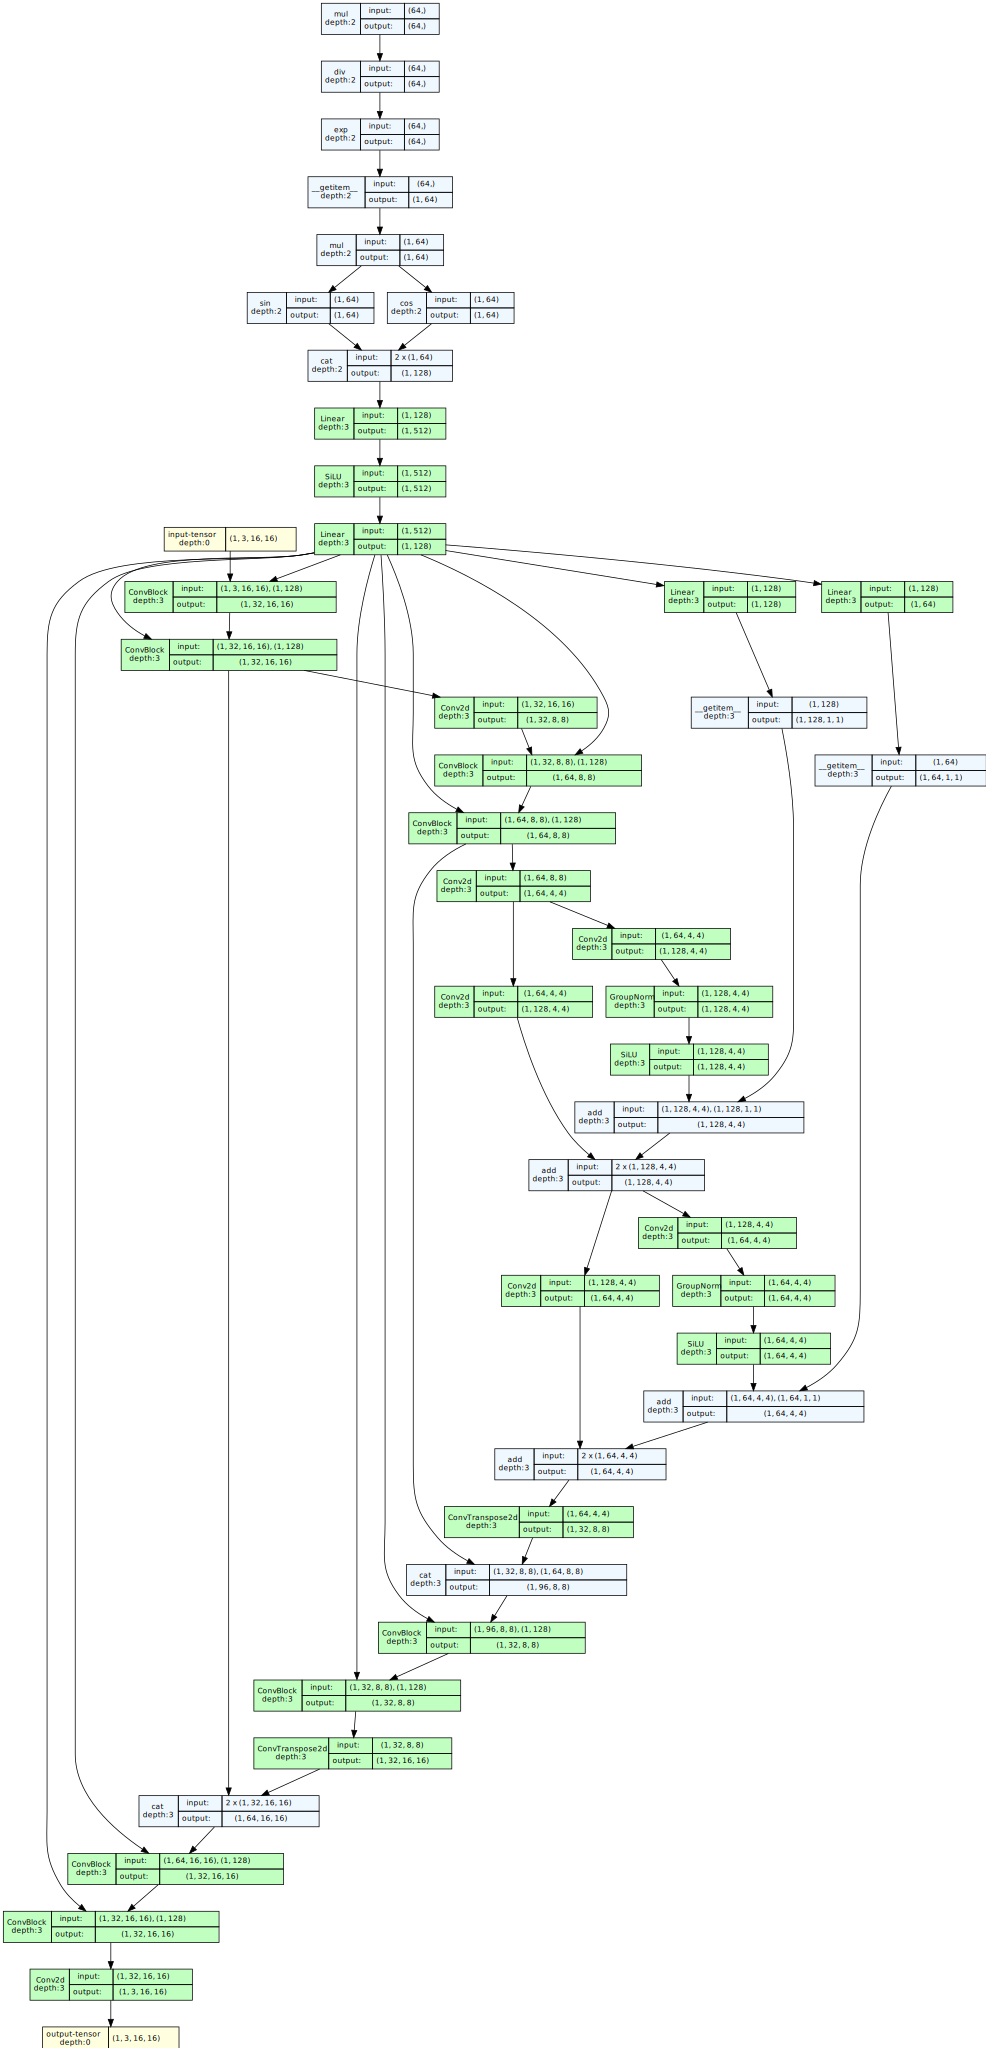

In [ ]:
## extrai um batch do seu dataloader
batch = next(iter(dataloader))
x_sample = batch["image"].to(device)

# Pegar um batch pequeno
x_sample = x_sample[:1]

# Criar uma classe para fixar o timestep
class WrappedUNet(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
    def forward(self, x):
        t = torch.tensor([500], device=x.device)  # timestep fixo
        return self.unet(x, t)

wrapped_model = WrappedUNet(model)

# Desenhar o diagrama
graph = draw_graph(wrapped_model,
                   input_data=x_sample,
                   graph_name="U-Net Pixel Art",
                   roll=True)
graph.visual_graph

### **Treinando o Modelo**

Com o modelo pronto, definimos o $\beta$ Schedule para o processo de difusão com T=500 passos, calculando o alpha_bar que mostra quanto do sinal original ainda é preservado em cada etapa. Configuramos o otimizador `AdamW` e treinamos a U-Net por 10 épocas para que ela aprendesse a prever o ruído adicionado.

In [ ]:
model.train()
print(f"Treinando modelo com {epochs} épocas...")

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for batch_idx, batch in enumerate(dataloader):
        # x0 é imagem original do batch
        x0 = batch["image"].to(device) if isinstance(batch, dict) else batch.to(device)

        # ruído gaussiano
        noise = torch.randn_like(x0)

        # amostra t aleatório para cada item do batch
        t = torch.randint(0, T, (x0.size(0),), device=device)

        # gera imagem com ruído parcial x_t a partir de x0
        xt = q_sample(x0, t, noise)

        # prediz o ruído que foi adicionado
        pred = model(xt, t)

        # calcula a loss MSE entre ruído real e previsto
        loss = F.mse_loss(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"Época {epoch+1}/{epochs} – loss médio: {avg_loss:.4f}")

Treinando modelo com 10 épocas...
Época 1/10 – loss médio: 0.1146
Época 2/10 – loss médio: 0.0673
Época 3/10 – loss médio: 0.0584
Época 4/10 – loss médio: 0.0532
Época 5/10 – loss médio: 0.0504
Época 6/10 – loss médio: 0.0491
Época 7/10 – loss médio: 0.0464
Época 8/10 – loss médio: 0.0451
Época 9/10 – loss médio: 0.0442
Época 10/10 – loss médio: 0.0437


### **Processo Reverso**

Após o treinamento, finalmente podemos executar o processo *reverse* de amostragem. Começaremos com puro ruído gerado pelo `torch.randn` e aplicaremos a U-Net em cada timestep, reconstruindo gradualmente algo próximo à distribuição original do dataset.

In [ ]:
@torch.no_grad()
def p_sample_ddpm(model, x, t, betas, alphas, alpha_bar, add_noise=True):
    B = x.size(0)
    t_tensor = torch.full((B,), t, device=device, dtype=torch.long)

    # Predição do ruído
    pred_noise = model(x, t_tensor)

    # Parâmetros
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    # Média do posterior
    coeff1 = 1 / torch.sqrt(alpha_t)
    coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = coeff1 * (x - coeff2 * pred_noise)

    if add_noise and t > 0:
        # Variância melhorada
        alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0)
        posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)
        x_prev = mean + torch.sqrt(posterior_variance) * noise
    else:
        x_prev = mean

    return x_prev

In [ ]:
frames = []

# Gerar valor inicial aleatório
x = torch.randn(8, 3, 16, 16, device=device)

# Executar reverse
for t in reversed(range(T)):
    x = p_sample_ddpm(model, x, t, betas, alphas, alpha_bar)
    if t % 50 == 0 or t < 5:

        # lista de imagens individuais
        imgs = [im.cpu().detach() for im in x]

        # cria separacao entre as imagens
        pad = torch.ones((3, 16, 2))  # (C, H, W)

        # intercala imagens e padding
        concat_list = []
        for i, img in enumerate(imgs):
            concat_list.append(img)
            if i < len(imgs)-1:
                concat_list.append(pad)

        # empilha horizontalmente
        img_grid = torch.cat(concat_list, dim=2).permute(1,2,0)
        img_grid = (img_grid.clamp(-1,1)+1)/2  # [0,1]
        img_grid = (img_grid.numpy() * 255).astype('uint8')
        frames.append(img_grid)

# cria GIF
imageio.mimsave("diffusion_process.gif", frames, fps=4, loop=0)
Im2(filename="diffusion_process.gif", width=700)

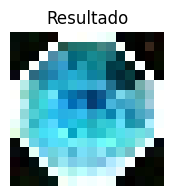

In [ ]:
# Gerar valor inicial aleatório
x = torch.randn(1, 3, 16, 16, device=device)

# Executar reverse
for t in reversed(range(T)):
    x = p_sample_ddpm(model, x, t, betas, alphas, alpha_bar )

# Converte para imagem visualizável
img_final = torch.cat([im for im in x.cpu().detach()], dim=2).permute(1,2,0)
img_final = (img_final.clamp(-1,1)+1)/2  # para [0,1]
img_final = (img_final.numpy() * 255).astype('uint8')

# Mostra imagem
plt.figure(figsize=(2,2))
plt.imshow(img_final)
plt.axis('off')
plt.title("Resultado")
plt.show()